In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from math import sqrt

def analyze_prepared_data(df, title):
    # Specify features and target based on the prepared DataFrame columns
    features = [col for col in df.columns if col != 'Actual Lead Time']
    target = 'Actual Lead Time'
    
    # Assuming df_train is your DataFrame, and 'features' and 'target' are defined

    # Initialize lists to store metrics
    min_errors = []
    max_errors = []
    average_errors = []
    median_errors = []
    rmses = []
    r2_scores = []

    # Number of runs
    n_runs = 10

    for _ in range(n_runs):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=None)
        
        # Define and train the model
        model = RandomForestRegressor(random_state=None)  
        model.fit(X_train, y_train.values.ravel())
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate errors
        errors = np.abs(y_test.values.ravel() - y_pred)
        
        # Collect metrics
        min_errors.append(np.min(errors))
        max_errors.append(np.max(errors))
        average_errors.append(np.mean(errors))
        median_errors.append(np.median(errors))
        rmses.append(sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))

    # Prepare data for plotting
    metrics = [min_errors, max_errors, average_errors, median_errors, rmses, r2_scores]
    metric_names = ['Min Error', 'Max Error', 'Average Error', 'Median Error', 'RMSE', 'R-squared']

    # Plotting
    fig, axs = plt.subplots(nrows=1, ncols=len(metric_names), figsize=(20, 6), sharey=False)
    for i, metric in enumerate(metrics):
        axs[i].boxplot(metric)
        axs[i].set_title(metric_names[i])

    plt.tight_layout()
    plt.suptitle(title+': Performance Metrics Across 10 Runs', fontsize=16, y=1.02)  # Add suptitle
    plt.show()



    # Identify and plot effects of the top 5 most important features
    top_indices = np.argsort(model.feature_importances_)[-10:]
    top_features = [features[i] for i in top_indices]

    top_importances = model.feature_importances_[top_indices]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.barh(top_features, top_importances, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title(title+': Top 5 Most Important Features')
    plt.show()
    '''
    # Initialize a dictionary to hold the effects for each feature across deltas from 1 to 10
    effects = {feature: [] for feature in top_features}

    for delta in range(1, 15):
        for feature in top_features:
            # Create a modified copy of X_test for the current feature and delta
            X_test_modified = X_test.copy()
            X_test_modified[feature] += delta

            # Make predictions with the original and modified datasets
            predictions_original = model.predict(X_test)
            predictions_modified = model.predict(X_test_modified)

            # Calculate the average effect of the delta
            average_effect = np.mean(predictions_modified - predictions_original)
            effects[feature].append(average_effect)

    # Plotting effects of feature deltas
    fig, ax = plt.subplots(figsize=(10, 6))
    for feature, deltas_effects in effects.items():
        ax.plot(range(1, 15), deltas_effects, marker='o', label=feature)
    ax.set_xlabel('Delta')
    ax.set_ylabel('Average Change in Prediction')
    ax.set_title(title+': Effect of Delta 1 to 10 on Top 5 Features')
    ax.legend()
    plt.grid(True)
    plt.show()
    '''


In [3]:
import pandas as pd

def df_date_filter(df, start, end):
    """
    Filters the provided DataFrame for entries between the specified start and end dates.

    Parameters:
        df (DataFrame): The DataFrame to filter.
        start (str or pd.Timestamp): The start date for the filter.
        end (str or pd.Timestamp): The end date for the filter.

    Returns:
        DataFrame: A filtered DataFrame containing only the entries within the specified date range.
    """

    # Create the mask for the date range
    mask = (df['Order Entry Date'] >= start) & (df['Order Entry Date'] <= end)
    filtered_df = df.loc[mask]
    categories = ['Country', 'Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 
            'Vendor Incoterm', 'Reason Code', 'Item Tracer Category','Framework Contract']
    numeric=['Manufacture','Pick Up','Quality Assurance','Illustrative Price','Ordered Quantity','Shipped Quantity','Number of Shipments',
         'RO Validation','Sourcing and Planning','USAID Approval','Process PO/DO','Reason Code Duration']
    features=categories+numeric
    target = ['Actual Lead Time']

    df_train = filtered_df[features+target]
    df_train.dropna(inplace=True)
    return df_train


In [4]:
df=pd.read_csv('USAID_Health_Comodity_Delivery.csv')
df['Vendor Incoterm'].unique()

categories = ['Country', 'Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 
        'Vendor Incoterm', 'Reason Code', 'Item Tracer Category','Framework Contract']
numeric=['Manufacture','Pick Up','Quality Assurance','Illustrative Price','Ordered Quantity','Shipped Quantity','Number of Shipments',
        'RO Validation','Sourcing and Planning','USAID Approval','Process PO/DO','Reason Code Duration']


21


In [5]:
import pandas as pd
#Read from file
df=pd.read_csv('USAID_Health_Comodity_Delivery.csv')

df['Latest Actual Delivery Date'] = pd.to_datetime(df['Latest Actual Delivery Date'])
df['Order Entry Date'] = pd.to_datetime(df['Order Entry Date'])

# Create the new column
df['Actual Lead Time'] = df['Latest Actual Delivery Date'] - df['Order Entry Date']
df['Actual Lead Time'] = df['Actual Lead Time'].dt.days

#Modify the reason code
df['Reason Code'] = df['Reason Code'].str.slice(0, 2)


categories = ['Country', 'Transportation Mode', 'Order Type', 'Fulfillment Method', 'Product Category', 
        'Vendor Incoterm', 'Reason Code', 'Item Tracer Category','Framework Contract']
numeric=['Manufacture','Pick Up','Quality Assurance','Illustrative Price','Ordered Quantity','Shipped Quantity','Number of Shipments',
        'RO Validation','Sourcing and Planning','USAID Approval','Process PO/DO','Reason Code Duration']


# Label econding for the categorical data in df
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in categories:
    df[i] = le.fit_transform(df[i])

#For every nan value use the average of the column group by 'Product Category'
for i in numeric:
    df[i] = df[i].fillna(df.groupby('Product Category')[i].transform('mean'))



In [6]:
# Filter dataframes
whole_df = df_date_filter(df, df['Order Entry Date'].min(), df['Order Entry Date'].max())
after_covid_df = df_date_filter(df, '2020-01-01', df['Order Entry Date'].max())
before_covid_df = df_date_filter(df, df['Order Entry Date'].min(), '2020-01-01')
peak_df = df_date_filter(df, '2020-01-01', '2022-03-22')

# Using df_date_filter to get before and after peak periods separately
before_peak_df = df_date_filter(df, df['Order Entry Date'].min(), '2019-12-31')
after_peak_df = df_date_filter(df, '2022-03-23', df['Order Entry Date'].max())

# Concatenating both DataFrames to create a non-peak DataFrame
non_peak_df = pd.concat([before_peak_df, after_peak_df], ignore_index=True)

# Optionally, you can print the number of records in each DataFrame to validate the splits
print("Whole period records:", len(whole_df))
print("After COVID records:", len(after_covid_df))
print("Before COVID records:", len(before_covid_df))
print("Peak period records:", len(peak_df))
print("Non-peak period records:", len(non_peak_df))


Whole period records: 16048
After COVID records: 6934
Before COVID records: 9114
Peak period records: 5655
Non-peak period records: 10393


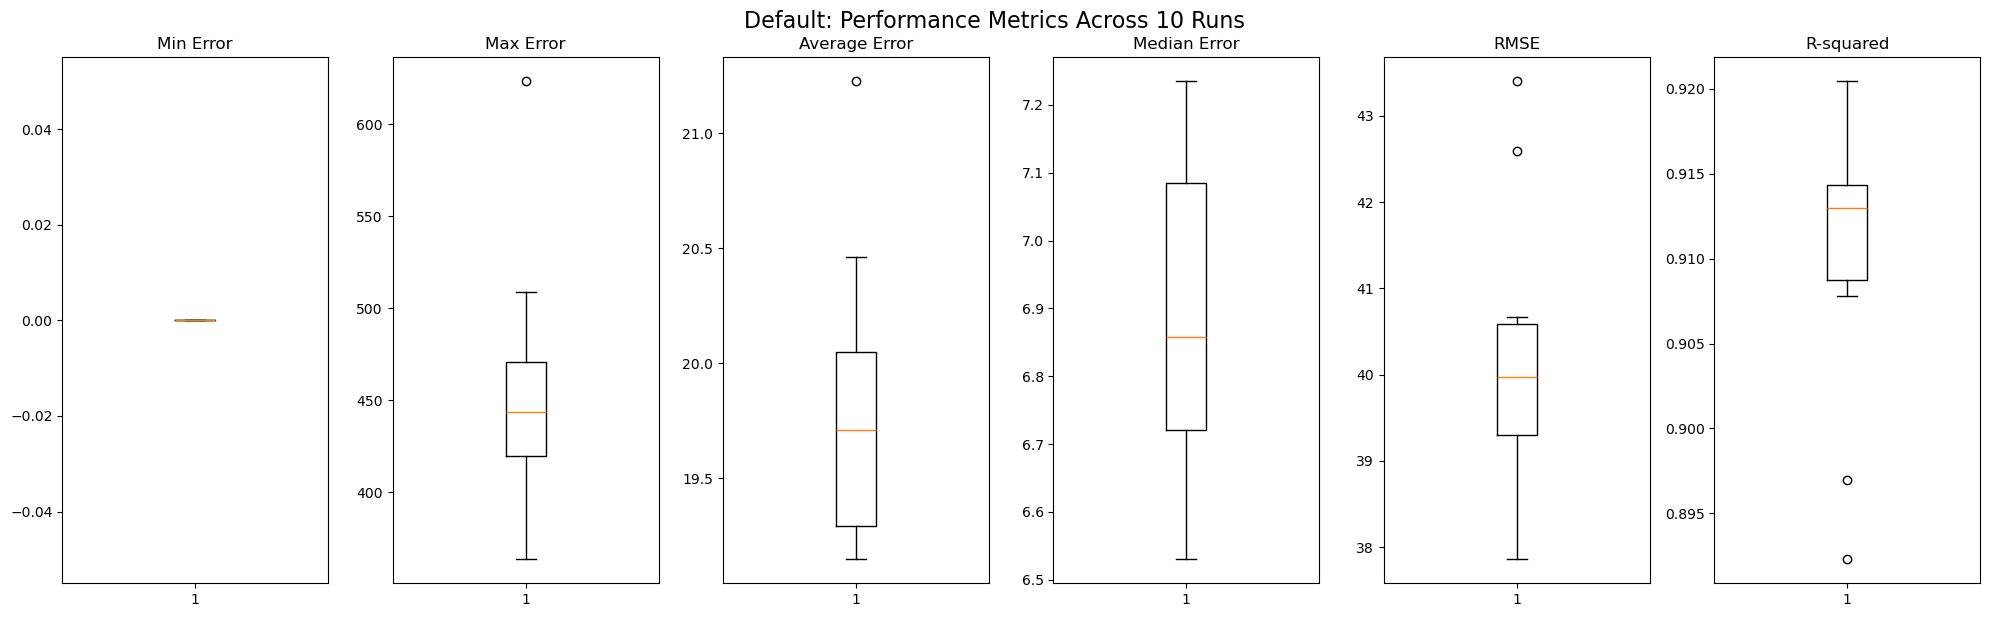

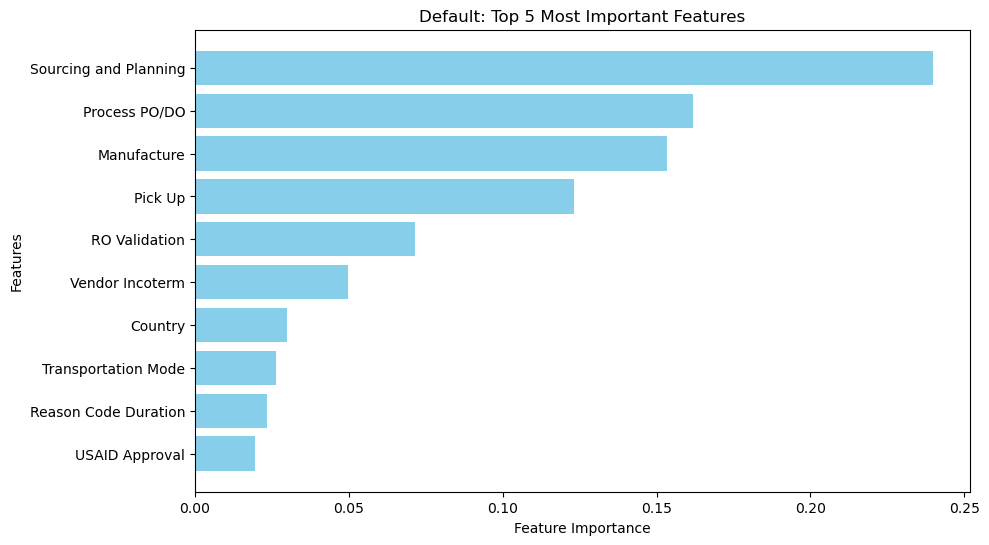

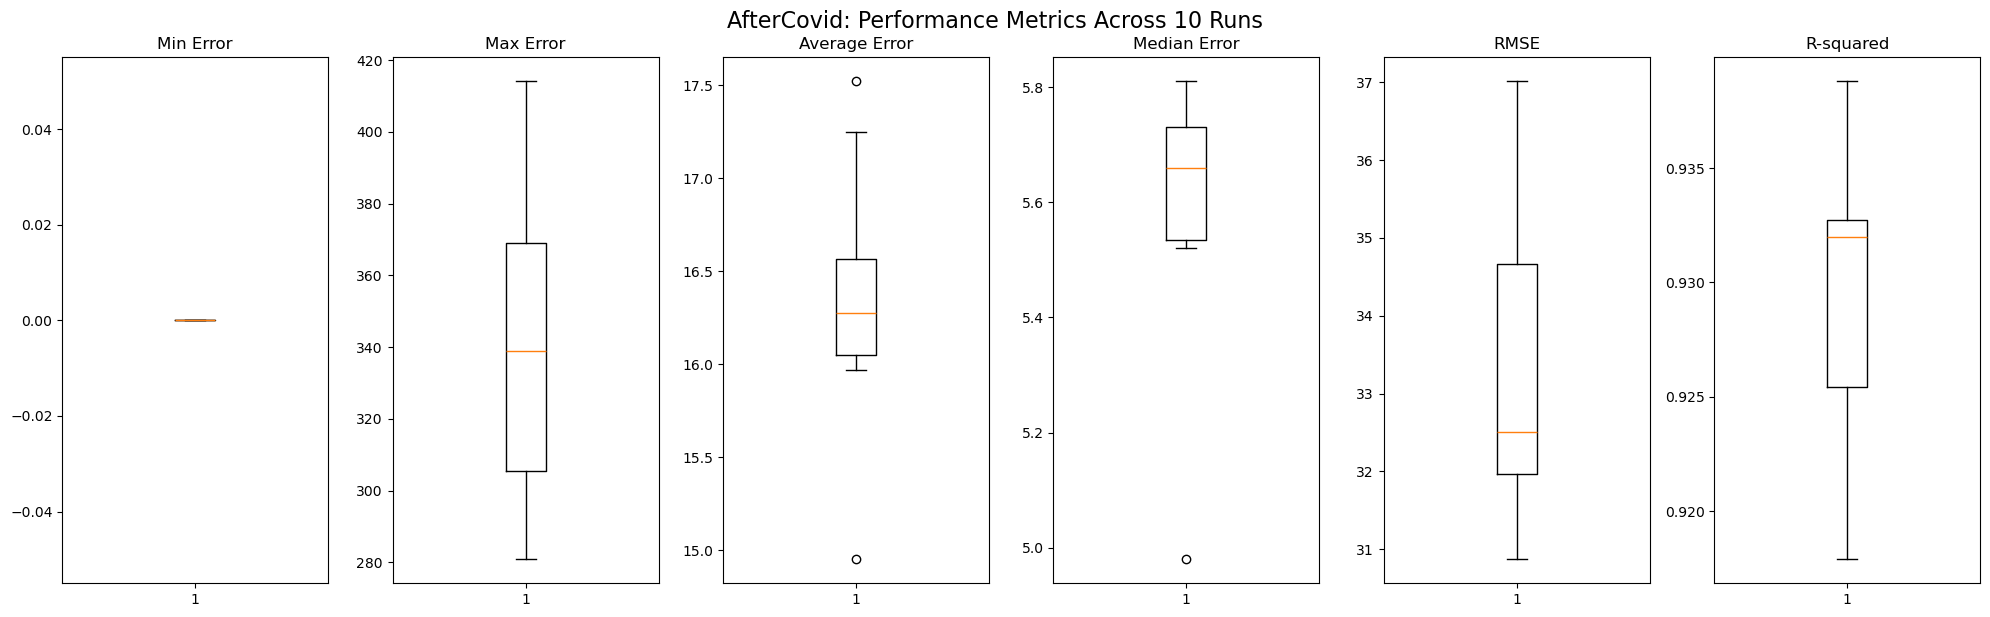

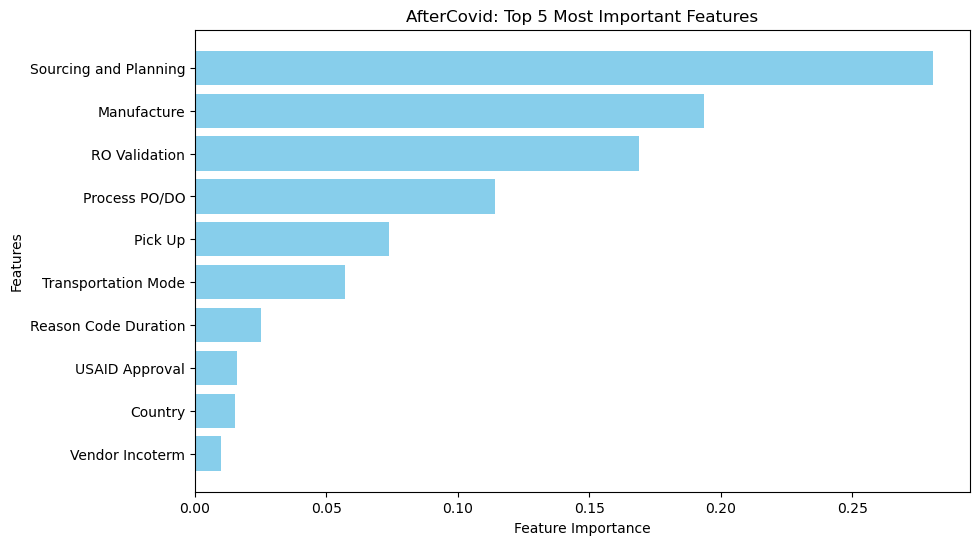

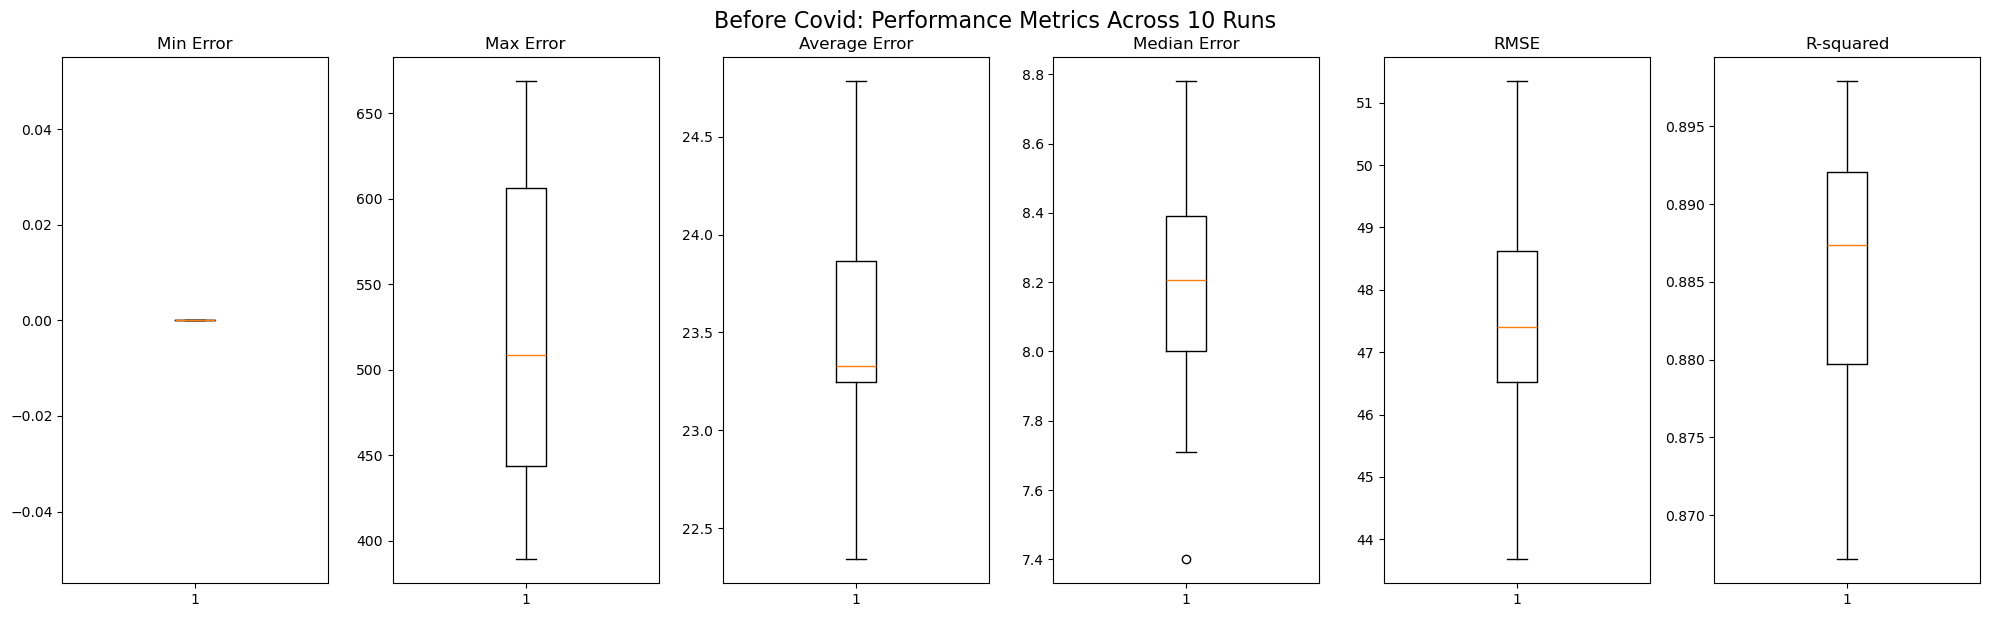

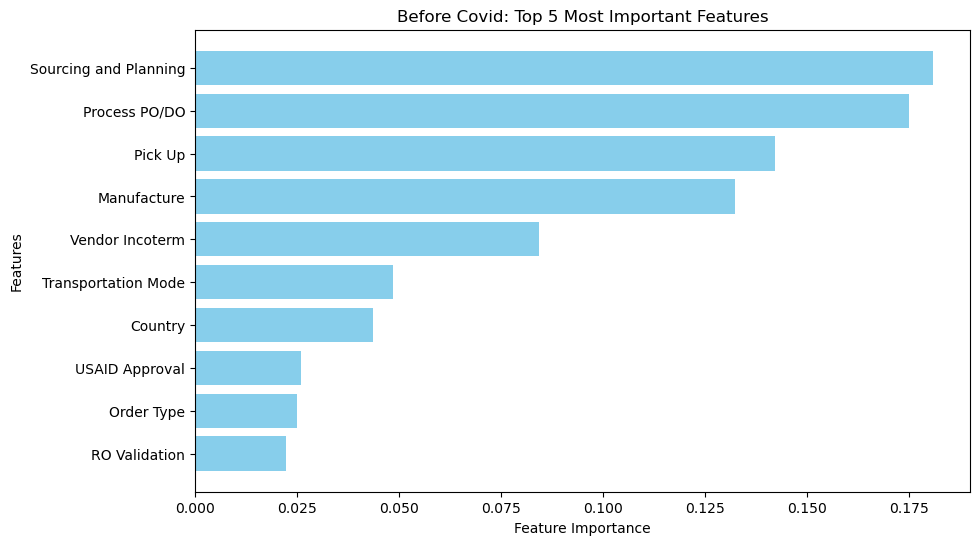

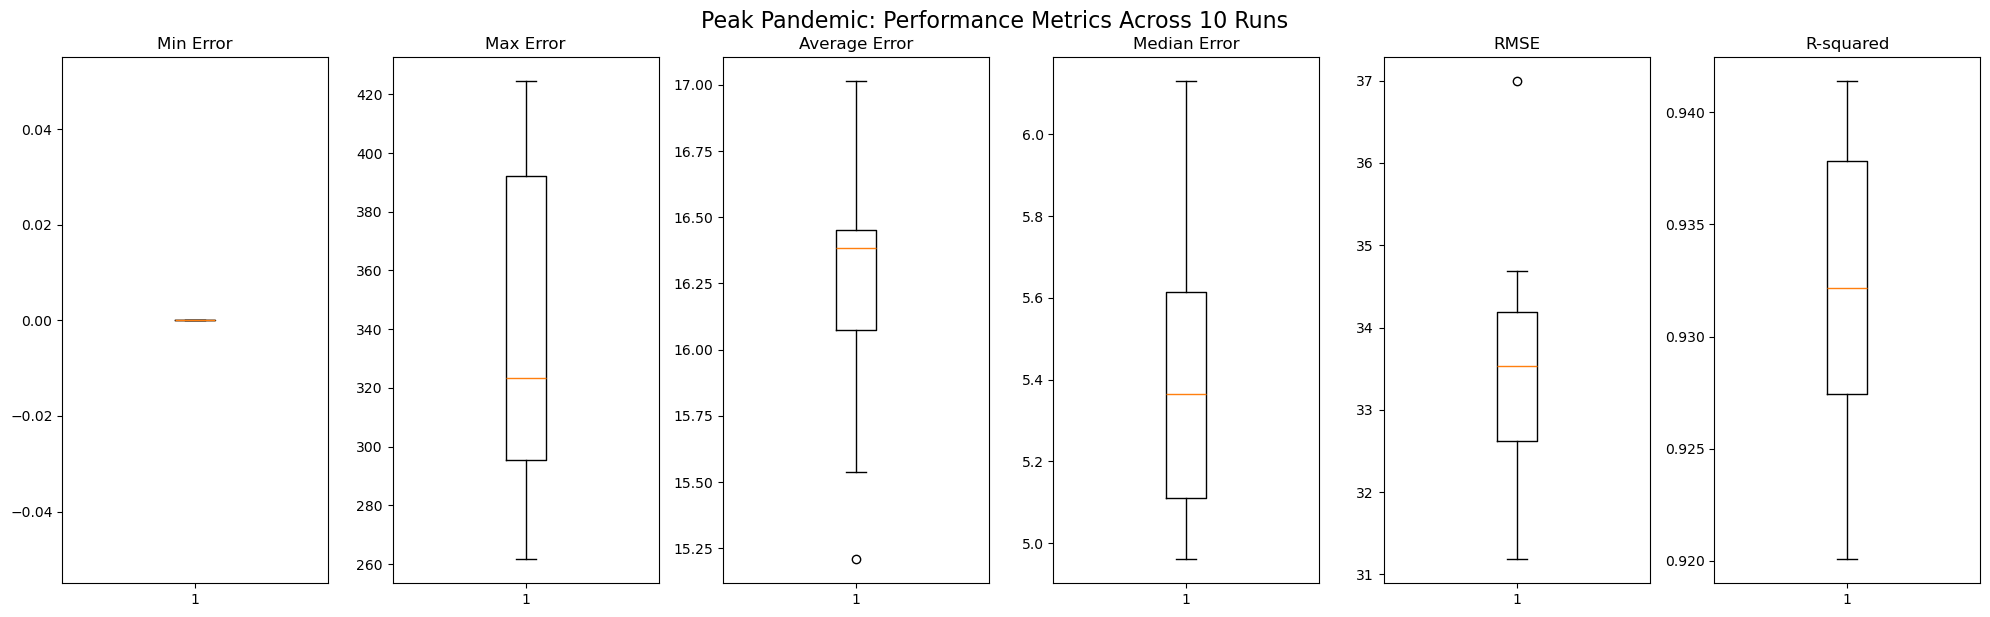

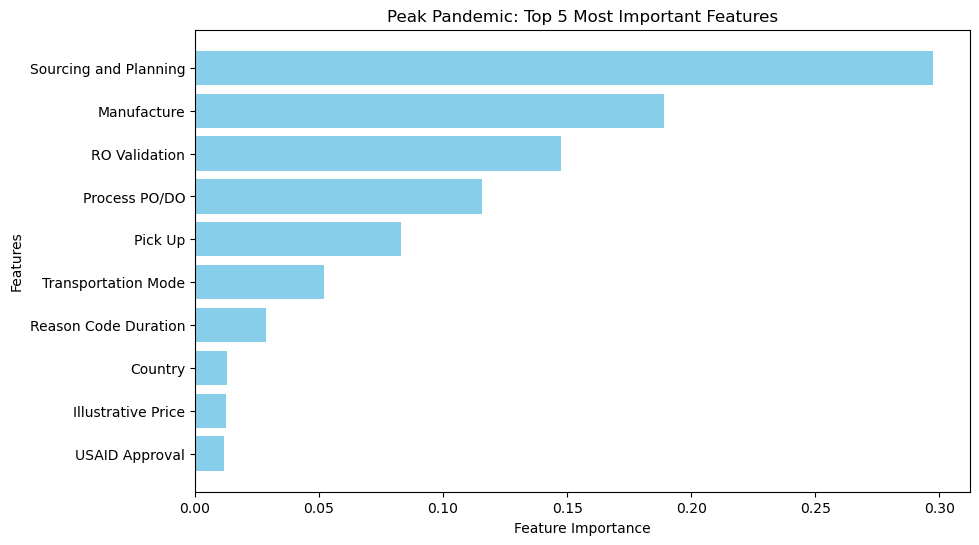

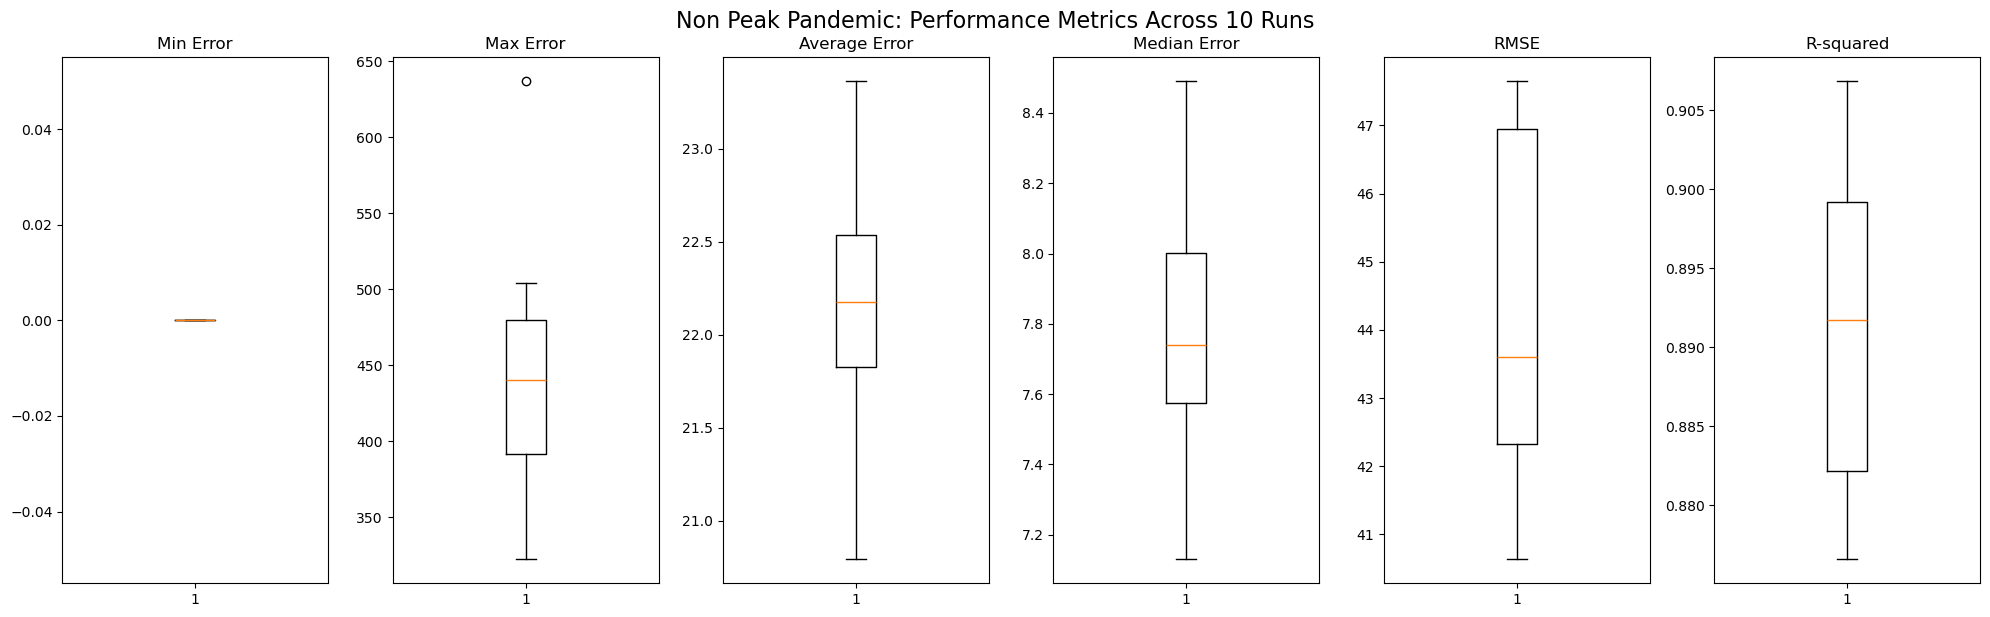

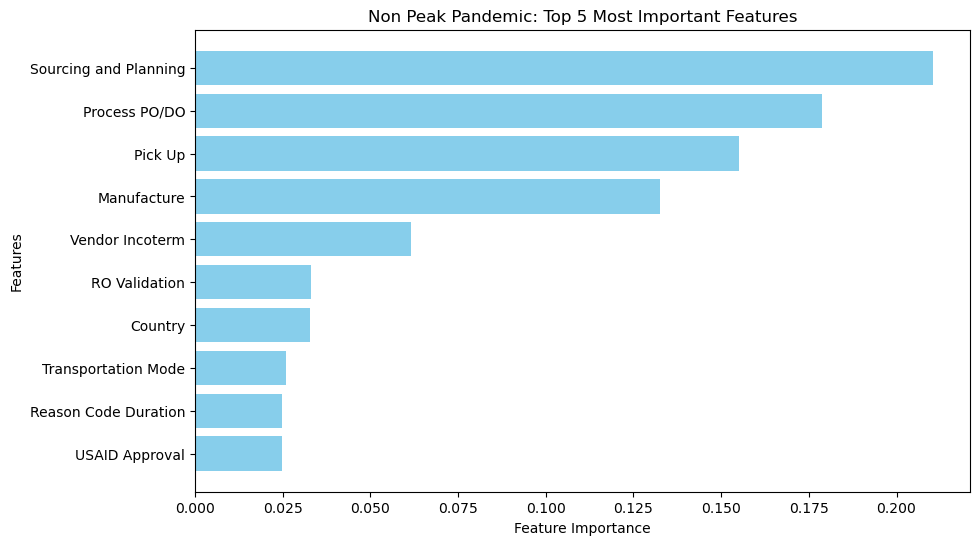

In [7]:
analyze_prepared_data(whole_df,'Default')
analyze_prepared_data(after_covid_df,'AfterCovid')
analyze_prepared_data(before_covid_df,'Before Covid')
analyze_prepared_data(peak_df,'Peak Pandemic')
analyze_prepared_data(non_peak_df,'Non Peak Pandemic')